<a href="https://colab.research.google.com/github/rahul-727/NLP-Lab-work/blob/main/Rahul_544_Lab_8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Implement the Weather Prediction using RNN and LSTM.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('/content/weather.csv')

In [4]:
df.head()

,date,precipitation,temp_max,temp_min,wind,weather
0,2012-01-01,0.0,12.8,5.0,4.7,drizzle
1,2012-01-02,10.9,10.6,2.8,4.5,rain
2,2012-01-03,0.8,11.7,7.2,2.3,rain
3,2012-01-04,20.3,12.2,5.6,4.7,rain
4,2012-01-05,1.3,8.9,2.8,6.1,rain


In [5]:
df.isnull().sum()

date             0
precipitation    0
temp_max         0
temp_min         0
wind             0
weather          0
dtype: int64

In [6]:
df.duplicated().sum()

0

In [7]:
training_set = df.iloc[:,2:3].values
training_set

array([[12.8],
       [10.6],
       [11.7],
       ...,
       [ 7.2],
       [ 5.6],
       [ 5.6]])

Extracts the temp_max column from the DataFrame and converts it into a numpy array training_set. This array is used to train the LSTM model.

In [8]:
len(training_set)

1461

In [9]:
def df_to_XY(df,window_size=10):
 X_train=[]
 y_train=[]

 for i in range(10,len(training_set)):
    X_train.append(training_set[i-10:i,0])
    y_train.append(training_set[i,0])

 X_train, y_train = np.array(X_train), np.array(y_train)
 return X_train, y_train

This function transforms the time series data into a supervised learning problem. It creates sequences (X_train) of 10 previous days' temperatures (window_size=10) to predict the temperature of the next day (y_train).

In [10]:
WINDOW = 10
X,y = df_to_XY(df,WINDOW)
print(len(X),len(y))
X_train = X[:800]
y_train = y[:800]
X_val = X[800:1000]
y_val = y[800:1000]
X_test = X[1000:]
x_test = y[1000:]

1451 1451


#Reshaping(To add new dimensions)

In [11]:
X_train = np.reshape(X_train,(X_train.shape[0],X_train.shape[1],1))
X_val = np.reshape(X_val,(X_val.shape[0],X_val.shape[1],1))
X_test = np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))

The input data (X_train, X_val, X_test) is reshaped to fit the LSTM's expected input format: [samples, time steps, features]. Here, we have 1 feature (temperature), and the number of time steps equals the window size.

#Building the RNN

In [12]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

In [13]:
regressor = Sequential()

#Adding the first LSTM layer and some Dropout regularisation

In [14]:
regressor.add(LSTM(units=50, return_sequences = True, input_shape=(X_train.shape[1], 1)))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units=50, return_sequences = True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units=50, return_sequences = True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units=50))
regressor.add(Dropout(0.2))

#Output layer
regressor.add(Dense(units=1))

In [15]:
regressor.compile(optimizer='adam',loss='mean_squared_error')

In [16]:
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam


#Fitting the RNN to the training set

In [17]:
history=regressor.fit(X_train,y_train,validation_data=(X_val,y_val),epochs=100, batch_size=32)

Epoch 1/100
25/25 [==============================] - 18s 122ms/step - loss: 207.7587 - val_loss: 240.7901
Epoch 2/100
25/25 [==============================] - 1s 38ms/step - loss: 89.3118 - val_loss: 152.5743
Epoch 3/100
25/25 [==============================] - 1s 35ms/step - loss: 67.5887 - val_loss: 125.0919
Epoch 4/100
25/25 [==============================] - 1s 22ms/step - loss: 59.6227 - val_loss: 108.5825
Epoch 5/100
25/25 [==============================] - 1s 22ms/step - loss: 56.7129 - val_loss: 97.4152
Epoch 6/100
25/25 [==============================] - 1s 23ms/step - loss: 54.2320 - val_loss: 89.4643
Epoch 7/100
25/25 [==============================] - 1s 23ms/step - loss: 54.8802 - val_loss: 85.0392
Epoch 8/100
25/25 [==============================] - 1s 25ms/step - loss: 54.7117 - val_loss: 81.0792
Epoch 9/100
25/25 [==============================] - 1s 24ms/step - loss: 53.8074 - val_loss: 78.8591
Epoch 10/100
25/25 [==============================] - 1s 23ms/step - loss: 

In [18]:
his = pd.DataFrame(history.history)

In [19]:
his.head()

,loss,val_loss
0,207.758652,240.790085
1,89.311806,152.574280
2,67.588699,125.091927
3,59.622730,108.582489
4,56.712925,97.415154


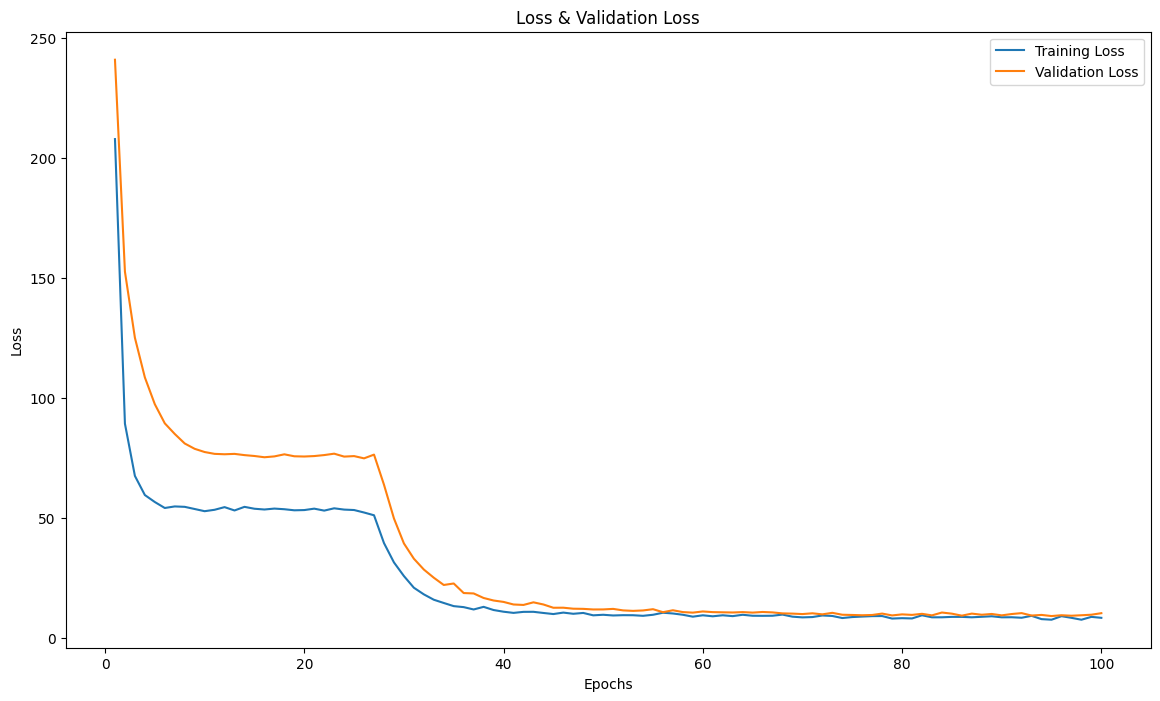

In [20]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(14, 8))
plt.title("Loss & Validation Loss")

epochs = range(1, len(history.history['loss']) + 1)

sns.lineplot(x=epochs, y=history.history['loss'], label='Training Loss', ax=ax)
sns.lineplot(x=epochs, y=history.history['val_loss'], label='Validation Loss', ax=ax)

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [21]:
train_pred = regressor.predict(X_train).flatten()
val_pred = regressor.predict(X_val).flatten()
test_pred = regressor.predict(X_test).flatten()

15/15 [==============================] - 0s 6ms/step


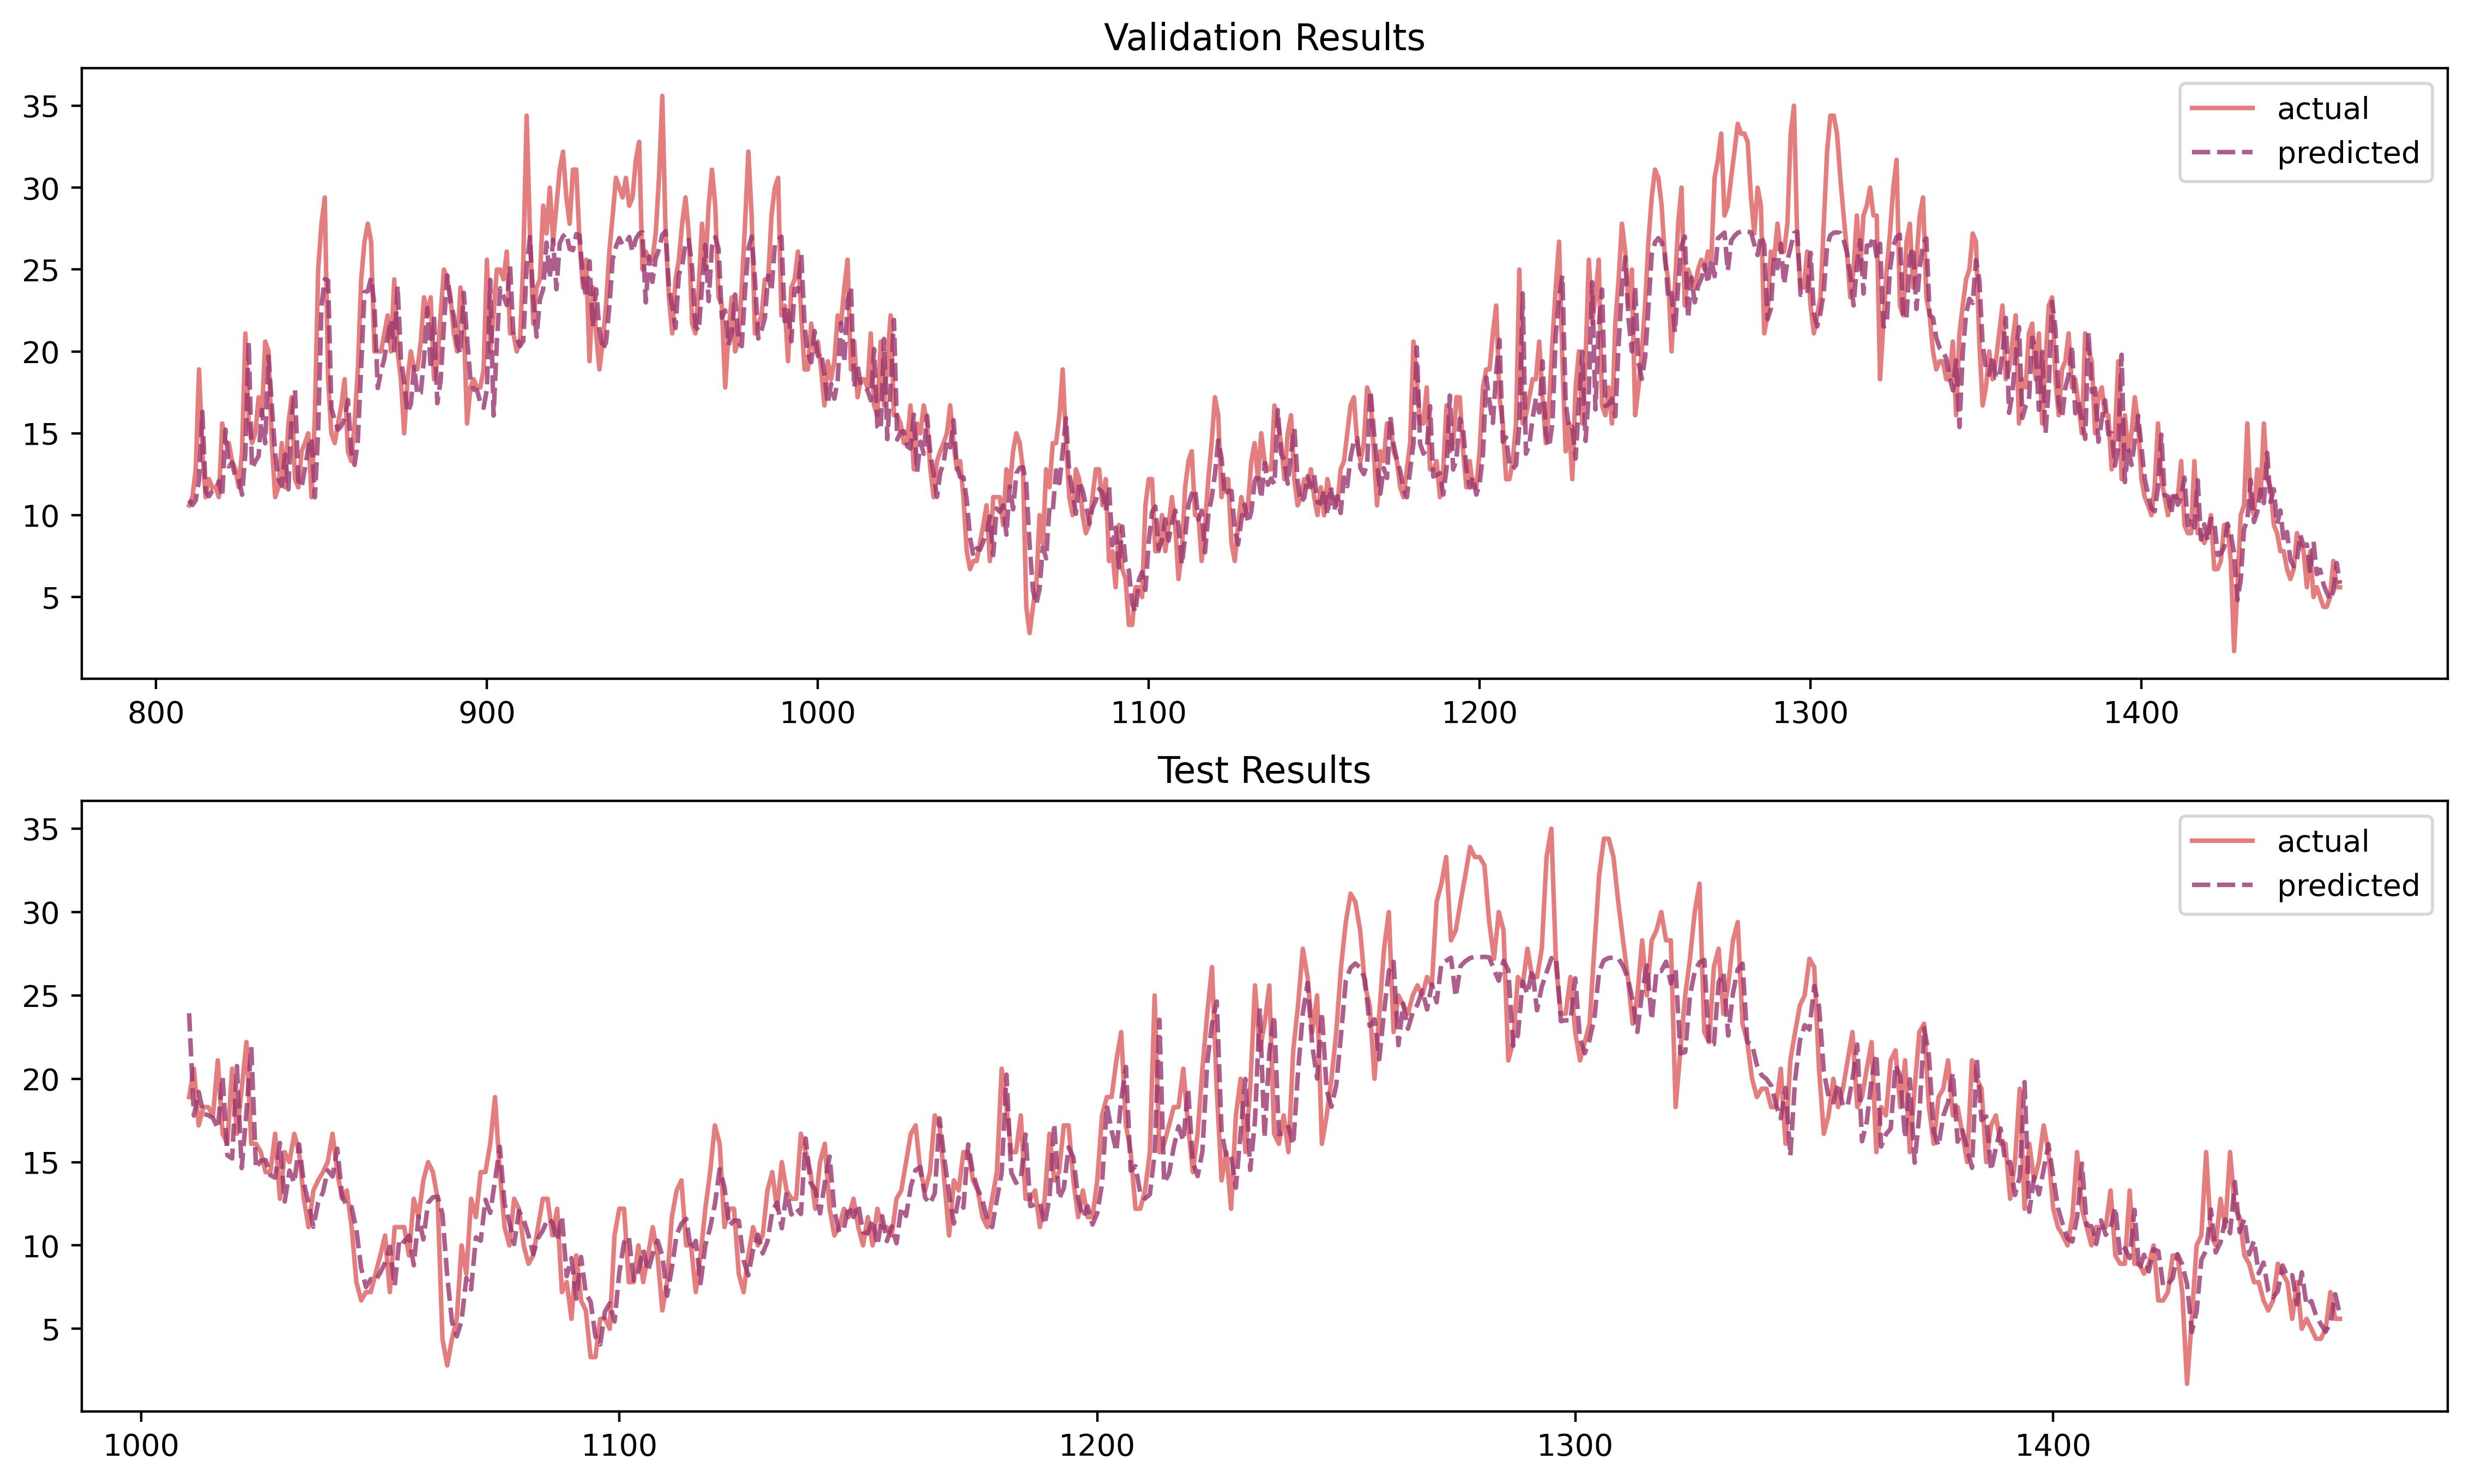

In [22]:
pred = np.concatenate([train_pred,val_pred,test_pred])
df_pred = pd.DataFrame(df["temp_max"].copy())
df_pred.columns=["actual"]
df_pred = df_pred[WINDOW:]
df_pred["predicted"] = pred

fig,axes = plt.subplots(2,1,figsize=(14,8),dpi=400)

plt.subplot(2,1,1)
plt.title("Validation Results")
sns.lineplot(df_pred[800:],alpha=0.8,palette="flare",linestyle=None);

plt.subplot(2,1,2)
plt.title("Test Results")
sns.lineplot(df_pred[1000:],alpha=0.8,palette="flare",linestyle=None);

# 2. Implement the Machine Translation using code

In [23]:
from transformers import MarianMTModel, MarianTokenizer

model_name = "Helsinki-NLP/opus-mt-en-fr"
tokenizer = MarianTokenizer.from_pretrained(model_name)
model = MarianMTModel.from_pretrained(model_name)

input_text = "Hi, my name is RK."

inputs = tokenizer(input_text, return_tensors="pt", padding=True, truncation=True)

translated = model.generate(**inputs)

translated_text = tokenizer.decode(translated[0], skip_special_tokens=True)

print("Translated text:", translated_text)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

source.spm:   0%|          | 0.00/778k [00:00<?, ?B/s]

target.spm:   0%|          | 0.00/802k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.34M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.42k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/marian/tokenization_marian.py:197: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


pytorch_model.bin:   0%|          | 0.00/301M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

Translated text: Bonjour, mon nom est RK.


translating English text to French using a pre-trained model from the Hugging Face transformers library